# Preliminary Steps

## Imports

In [2]:
from dotenv import load_dotenv

import os

import datetime

# import traceback

from sql_query_helper_funcs import exec_and_commit_query, sql_query_to_pandas_df

import pandas as pd

from sqlalchemy import create_engine

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

import statsmodels.api as sm

from scipy import stats

## Connecting to local db

In [3]:
load_dotenv()

True

In [4]:
db_user = os.environ.get('USER_NAME')
db_pass = os.environ.get('PASS')
db_ip = os.environ.get('IP_ADDRESS')
db_port = os.environ.get('PORT')
db_name = os.environ.get('DB_NAME')

engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_pass}@{db_ip}:{db_port}/{db_name}')

# Summary Statistics

In [5]:
# This formats numbers in pandas DataFrames to have commas such that numbers
# are more legible.  Example: 214310 -> 214,310
pd.options.display.float_format = '{:,}'.format

## Summary Stats - Mean, Std Dev, and Five Number Summary of points

In [6]:
sql_query = """ 
WITH daily_points AS (
  SELECT event_date
       , SUM(points) AS points_per_event
    FROM event_performance
GROUP BY event_date
),

summary_stats AS (
  SELECT ROUND(AVG(points_per_event)
                ) AS avg_tot_pts_per_event
       , ROUND(STDDEV(points_per_event)
                ) AS std_dev_tot_pts_per_event
       , MIN(points_per_event) AS min_event_pts
       , PERCENTILE_CONT(0.25)
           WITHIN GROUP (ORDER BY points_per_event) AS q1_event_pts
       , PERCENTILE_CONT(0.5) 
           WITHIN GROUP (ORDER BY points_per_event) AS median_event_pts
       , PERCENTILE_CONT(0.75) 
           WITHIN GROUP (ORDER BY points_per_event) AS q3_event_pts
       , MAX(points_per_event) AS max_event_pts
    FROM daily_points
    ),
    
row_summary_stats AS (

  SELECT 1 AS num
       , 'num_gaming_events' AS statistic
       , COUNT(DISTINCT event_date) AS value
    FROM event_performance
   UNION
  SELECT 2
       , 'num_unique_users'
       , COUNT(userid)
    FROM users
   UNION
  SELECT 3
       , 'participating_users_pct'
       , ROUND((SELECT COUNT(DISTINCT userid) FROM event_performance)::NUMERIC / 
           (SELECT COUNT(userid) FROM users), 4) * 100
   UNION
  SELECT 4 AS num
       , 'avg_tot_pts_per_event'
       , avg_tot_pts_per_event
    FROM summary_stats
   UNION
  SELECT 5
       , 'std_dev_tot_pts_per_event'
       , std_dev_tot_pts_per_event
    FROM summary_stats
   UNION
  SELECT 6
       , 'min_event_pts'
       , min_event_pts
    FROM summary_stats
   UNION
  SELECT 7
       , 'q1_event_pts'
       , q1_event_pts
    FROM summary_stats
   UNION
  SELECT 8
       , 'median_event_pts'
       , median_event_pts
    FROM summary_stats
   UNION
  SELECT 9
       , 'q3_event_pts'
       , q3_event_pts
    FROM summary_stats
   UNION
  SELECT 10
       , 'max_event_pts'
       , max_event_pts
    FROM summary_stats
   UNION
  SELECT 11
       , 'range'
       , max_event_pts - min_event_pts
    FROM summary_stats
  )

  SELECT statistic
       , value
    FROM row_summary_stats
ORDER BY num;
"""

quantitative_summary_stats = sql_query_to_pandas_df(sql_query,
                                                    engine,
                                                    index_column='statistic')

quantitative_summary_stats

,value
statistic,
num_gaming_events,147.0
num_unique_users,"1,100.0"
participating_users_pct,89.09
avg_tot_pts_per_event,"49,375.0"
std_dev_tot_pts_per_event,"72,282.0"
min_event_pts,"-257,483.0"
q1_event_pts,"6,272.0"
median_event_pts,"26,713.0"
q3_event_pts,"75,072.5"


**Before proceeding with the analysis, some background on the company may be helpful.  This company runs periodic gaming events where its userbase plays cooperatively to earn points in order to beat an enemy.  Individual players can win or lose points based on certain things that happen in the game, however the total point score over all participating players is what matters for the win condition.**

**When the game ends, if the total number of points is positive, the users win the game and receive prizes that correspond to how many total points were earned.  For instance, if the game ends and all users have a combined total of 1,000 points, they'll earn better prizes than if their combined total was 100 points.  If the game ends and the users have a negative score, then the enemy wins and each user is forced to take a penalty.  The penalties are worse for larger negative points scores.  Now for the analysis...**

The table above shows summary statistics based on the total number of points earned over all users who participated during at least one gaming event.  Gaming events happen at most once a day, but when one occurs, it lasts for several hours and data on number of points scored for each userid is tracked on an hourly basis.  There were 147 gaming events that occurred in this dataset, with 89.09% of all 1,100 unique users participating in at least one gaming event.

The average of the total number of points per gaming event was 49,375, indicating the typical outcome is that the users are winners.  However, the standard deviation is large in comparison, sitting at 72,282 points, showing there is a fair bit of variance in points scored.  This is further supported by looking at the min and max values, which span from -257,483 to 408,321 points, corresponding to a rather large range of 665,804 points. 

We would expect a majority of gaming events to have total points earned within one standard deviation from the mean, or between -22,907 and 121,657 points.  Consequently, there were gaming events where the total number of points was negative, indicating the users lost. Despite the large amount of variation, the first quartile for total points earned during a gaming event sits at 6,272, meaning at least 75% of these events were wins for the userbase.

It's particularly important to note that the minimum for the total number of points earned in a gaming event was -257,483, which will be investigated further later on in the analysis.

**These findings are important because they give a general sense of the health of the company's user interactions.  While there is evidence that some gaming events result in losses for the users, a vast majority are wins.  The game seems to favor the user base heavily.  If this is desired, then leave the system as is, however if more balance is desired, then tweaks may need to be made to increase the enemy's chance of winning.**

## Summary Stats - Frequencies and Relative Frequencies of Attributes

In [7]:
sql_query = """ 
  SELECT subscriber::text AS attribute
       , COUNT(userid) AS num_users
       , ROUND(COUNT(userid):: NUMERIC / 
            SUM(COUNT(userid)) OVER (), 4) AS rel_freq
    FROM users
GROUP BY subscriber
UNION
  SELECT category AS attribute
       , COUNT(userid) AS num_users
       , ROUND(COUNT(userid)::NUMERIC / 
            SUM(COUNT(userid)) OVER (), 4) AS rel_freq
    FROM users
GROUP BY category
ORDER BY 1;
"""

sql_query_to_pandas_df(sql_query, engine, index_column='attribute')

,num_users,rel_freq
attribute,,
0,899,0.8173
1,201,0.1827
A,411,0.3736
B,445,0.4045
C,244,0.2218


In order to get a high-level understanding of the userbase, it's important to get a sense of what types of users are present.  The table above shows the distribution of users based on their attribute.  Subscriber is a binary variable of either 0 or 1, while category is a categorical variable having values A, B, or C.  

From the table, an overwhelming majority of users (\~81%) are not subscribers.  The majority of users (\~40%) fall in the B category; however, a nearly equal amount of users (\~37%) are in category A.

In [8]:
sql_query = """ 
  SELECT subscriber
       , category
       , COUNT(userid) AS num_users
       , ROUND(COUNT(userid):: NUMERIC / 
            SUM(COUNT(userid)) OVER (), 4) AS rel_freq
    FROM users
GROUP BY subscriber, category
ORDER BY subscriber, category;
"""

sql_query_to_pandas_df(sql_query, 
                       engine, 
                       index_column=['subscriber', 'category'])

num_users  rel_freq
subscriber category                     
0          A               342    0.3109
           B               353    0.3209
           C               204    0.1855
1          A                69    0.0627
           B                92    0.0836
           C                40    0.0364

Digging deeper, it looks like the most common user profile is 0B (non-subscriber in category B), with 0A (non-subscriber in category A) not that far behind.  Users who are subscribers are far rarer; however, among these users, those in the B category are still the most common, and those in category A are not far behind.  

**This is important because establishing these user profiles now will be helpful later in understanding which kinds of users are most helpful in winning a gaming event.**

## Summary Stats - Frequences and Relative Frequencies of User Types

In [9]:
sql_query = """
WITH user_types AS (
  SELECT userid, 'total_points_positive' AS user_type
    FROM event_performance
GROUP BY userid
  HAVING SUM(points) > 0
   UNION
  SELECT userid, 'total_points_negative'
    FROM event_performance
GROUP BY userid
  HAVING SUM(points) < 0
   UNION
  SELECT userid, 'total_points_zero'
    FROM event_performance
GROUP BY userid
  HAVING SUM(points) = 0
  )

  SELECT user_type
       , COUNT(user_type) AS num_users
       , ROUND(COUNT(user_type)::NUMERIC / 
           SUM(COUNT(user_type)) OVER (), 4) AS rel_freq
    FROM user_types
GROUP BY user_type
ORDER BY num_users DESC;
"""

sql_query_to_pandas_df(sql_query, engine, index_column='user_type')

,num_users,rel_freq
user_type,,
total_points_positive,700,0.7143
total_points_negative,279,0.2847
total_points_zero,1,0.001


Lastly, to understand user behavior a little better, it might be useful to look at the total number of points per userid for this dataset.  The table above shows a large majority of users (\~71%) where their yearly total number of points earned is positive, while most of the remaining users have yearly point totals that are negative, with one exception.  There's a user whose total points earned are 0. 

**These summary statistics are important as they also give some insight into the company's user interactions.  Because 71% of users have positive point totals, they must be consistently contributing points towards winning gaming events, and broadly speaking are successful roughly 71% of the time.**

# Visualizations

## Exploring By Month

### Total Points and Total Users Per Month

In [10]:
sql_query = """
  SELECT DATE_TRUNC('month', event_date)::date AS month
       , SUM(points) AS total_points
    FROM event_performance
GROUP BY DATE_TRUNC('month', event_date)::date
ORDER BY 1;
"""

total_points_per_month = sql_query_to_pandas_df(sql_query,
                                                engine,
                                                index_column='month',
                                                dates_column='month')

In [11]:
sql_query = """
  SELECT DATE_TRUNC('month', event_date)::date AS month
       , COUNT(DISTINCT userid) AS total_users
    FROM event_performance
GROUP BY DATE_TRUNC('month', event_date)::date
ORDER BY 1;
"""

total_users_per_month = sql_query_to_pandas_df(sql_query,
                                               engine,
                                               index_column='month',
                                               dates_column='month')

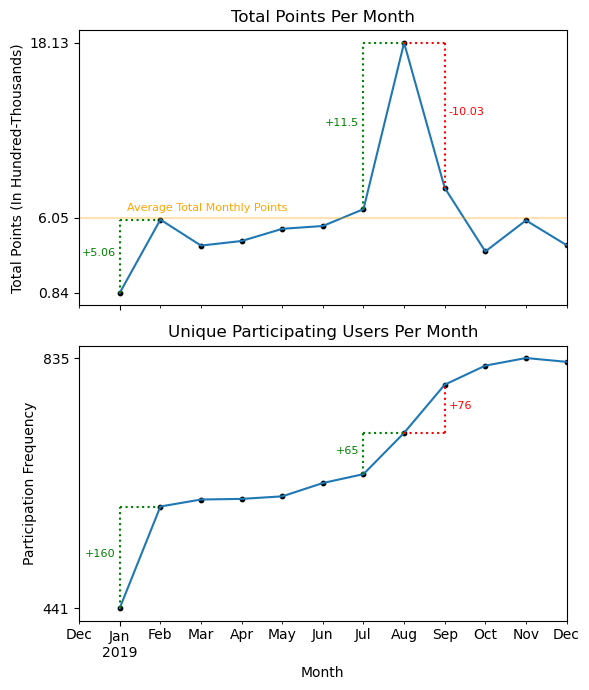

In [12]:
jan_tot_pts = total_points_per_month.loc['2019-01-01'].values[0]
feb_tot_pts = total_points_per_month.loc['2019-02-01'].values[0]
july_tot_pts = total_points_per_month.loc['2019-07-01'].values[0]
aug_tot_pts = total_points_per_month.loc['2019-08-01'].values[0]
sept_tot_pts = total_points_per_month.loc['2019-09-01'].values[0]

jan_tot_users = total_users_per_month.loc['2019-01-01'].values[0]
feb_tot_users = total_users_per_month.loc['2019-02-01'].values[0]
july_tot_users = total_users_per_month.loc['2019-07-01'].values[0]
aug_tot_users = total_users_per_month.loc['2019-08-01'].values[0]
sept_tot_users = total_users_per_month.loc['2019-09-01'].values[0]

avg_tot_pts_per_month = total_points_per_month.mean().values[0]
min_tot_pts_per_month = total_points_per_month.min().values[0]
max_tot_pts_per_month = total_points_per_month.max().values[0]

avg_tot_users_per_month = total_users_per_month.mean().values[0]
min_tot_users_per_month = total_users_per_month.min().values[0]
max_tot_users_per_month = total_users_per_month.max().values[0]

fig, ax = plt.subplots(2,1, sharex=True, figsize=(6,7))

total_points_per_month.plot(kind='line', legend=False, ax=ax[0])
ax[0].scatter(total_points_per_month.index, total_points_per_month.values, color='black', s=10)

ax[0].vlines('2019-01-01', ymin=jan_tot_pts, ymax=feb_tot_pts, linestyle=':', color='green')
ax[0].hlines(feb_tot_pts, xmin='2019-01-01', xmax='2019-02-01', linestyle=':', color='green')
ax[0].annotate(f'+{round((feb_tot_pts-jan_tot_pts)/100_000,2)}',
               xy=('2019-01-01', jan_tot_pts+(feb_tot_pts-jan_tot_pts)/2),
               textcoords='offset points',
               xytext=(-3,0), ha='right', color='green', fontsize=8)

ax[0].vlines('2019-07-01', ymin=july_tot_pts, ymax=aug_tot_pts, linestyle=':', color='green')
ax[0].hlines(aug_tot_pts, xmin='2019-07-01', xmax='2019-08-01', linestyle=':', color='green')
ax[0].annotate(f'+{round((aug_tot_pts-july_tot_pts)/100_000,2)}',
               xy=('2019-07-01', july_tot_pts+(aug_tot_pts-july_tot_pts)/2),
               textcoords='offset points',
               xytext=(-3,0), ha='right', color='green', fontsize=8)

ax[0].vlines('2019-09-01', ymin=aug_tot_pts, ymax=sept_tot_pts, linestyle=':', color='red')
ax[0].hlines(aug_tot_pts, xmin='2019-08-01', xmax='2019-09-01', linestyle=':', color='red')
ax[0].annotate(f'{round((sept_tot_pts-aug_tot_pts)/100_000,2)}',
               xy=('2019-09-01', aug_tot_pts+(sept_tot_pts-aug_tot_pts)/2),
               textcoords='offset points',
               xytext=(3,0), ha='left', color='red', fontsize=8)

ax[0].set_title('Total Points Per Month')
ax[0].set_xlabel('Month')
ax[0].set_yticks([min_tot_pts_per_month, avg_tot_pts_per_month, max_tot_pts_per_month])
ax[0].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(round(int(x)/100_000, 2), ',')))
ax[0].set_ylabel('Total Points (In Hundred-Thousands)')


ax[0].axhline(avg_tot_pts_per_month, linestyle='solid', color='orange', alpha=0.3)
ax[0].annotate("Average Total Monthly Points", 
               xy=('2019-01-01',
                   avg_tot_pts_per_month), 
               textcoords="offset points", 
               xytext=(5,5), c='orange', fontsize=8, ha='left')


total_users_per_month.plot(kind='line', legend=False, ax=ax[1])
ax[1].scatter(total_users_per_month.index, total_users_per_month.values, color='black', s=10)

ax[1].set_xlim([datetime.date(2018, 12, 1), datetime.date(2019, 12, 1)])

ax[1].vlines('2019-01-01', ymin=jan_tot_users, ymax=feb_tot_users, linestyle=':', color='green')
ax[1].hlines(feb_tot_users, xmin='2019-01-01', xmax='2019-02-01', linestyle=':', color='green')
ax[1].annotate(f'+{(feb_tot_users-jan_tot_users)}',
               xy=('2019-01-01', jan_tot_users+(feb_tot_users-jan_tot_users)/2),
               textcoords='offset points',
               xytext=(-3,0), ha='right', color='green', fontsize=8)

ax[1].vlines('2019-07-01', ymin=july_tot_users, ymax=aug_tot_users, linestyle=':', color='green')
ax[1].hlines(aug_tot_users, xmin='2019-07-01', xmax='2019-08-01', linestyle=':', color='green')
ax[1].annotate(f'+{(aug_tot_users-july_tot_users)}',
               xy=('2019-07-01', july_tot_users+(aug_tot_users-july_tot_users)/2),
               textcoords='offset points',
               xytext=(-3,0), ha='right', color='green', fontsize=8)

ax[1].vlines('2019-09-01', ymin=aug_tot_users, ymax=sept_tot_users, linestyle=':', color='red')
ax[1].hlines(aug_tot_users, xmin='2019-08-01', xmax='2019-09-01', linestyle=':', color='red')
ax[1].annotate(f'+{(sept_tot_users-aug_tot_users)}',
               xy=('2019-09-01', aug_tot_users+(sept_tot_users-aug_tot_users)/2),
               textcoords='offset points',
               xytext=(3,0), ha='left', color='red', fontsize=8)

ax[1].set_title('Unique Participating Users Per Month')
ax[1].set_xlabel('Month')
ax[1].set_yticks([min_tot_users_per_month, max_tot_users_per_month])
ax[1].set_ylabel('Participation Frequency')

plt.tight_layout();

The first graph shows all months have a sum of points greater than 0, which provides further evidence that overall, users are successfully contributing to winning gaming events. Late summer and early fall have the only three months that performed better than average, July, August, and September, with August being the best-performing month by a large margin. 

Looking at the second graph, these late spring and summer months correspond to times where there were some of the largest increases in user participation.  However, there was a large increase in user participation between January and February too.  While February had only roughly average performance, that month saw the second largest increase in total points earned for the entire year.

Outside of these best performing months, total points don't show much variation.  Points earned between February and July remain fairly consistent, which corresponds to the number of participating users stagnating over the same time period.  However, this trend doesn't hold true for the entire year as October, November, and December had the largest number of participating users, yet each of those months had point totals below average and show more variation than is found in February through July.

Lastly, January had the lowest number of participating users all year, which is probably a large contributing factor as to why January also had the lowest point performance.  Interestingly, despite August having the best point performance, it was 5th in terms of participating users.  

**These findings are important for two main reasons:**
1. **Total points earned show some seasonality, and identifying ways to increase user performance during the early spring, late fall, and throughout the winter months could be important to fostering growth and generating revenue.**

2. **Total points earned also shows some connection to number of participating users.  Consequently, identifying why the number of users increased rapidly between January and February at the start of the year, or during the late spring and early summer months, could be important to driving future growth and, in turn, additional revenue.**

### Total Points Per Month Based on User Type (Users With Positive Point Totals vs. Users With Negative Point Totals)

In [13]:
sql_query = """
WITH users_with_positive_totals AS (
  SELECT userid
    FROM event_performance
GROUP BY userid
  HAVING SUM(points) > 0
  )

SELECT DATE_TRUNC('month', event_date)::date AS month
     , SUM(points) AS total_positive_points
FROM event_performance
WHERE userid IN (SELECT userid FROM users_with_positive_totals)
GROUP BY DATE_TRUNC('month', event_date)
ORDER BY 1;
"""

users_total_positive_points_per_month = \
                                sql_query_to_pandas_df(sql_query,
                                                       engine,
                                                       index_column='month',
                                                       dates_column='month')

In [14]:
sql_query = """
WITH users_with_negative_totals AS (
  SELECT userid
    FROM event_performance
GROUP BY userid
  HAVING SUM(points) < 0
  )

SELECT DATE_TRUNC('month', event_date)::date AS month
     , SUM(points) AS total_negative_points
FROM event_performance
WHERE userid IN (SELECT userid FROM users_with_negative_totals)
GROUP BY DATE_TRUNC('month', event_date)
ORDER BY 1;
"""

users_total_negative_points_per_month = \
                                sql_query_to_pandas_df(sql_query,
                                                       engine,
                                                       index_column='month',
                                                       dates_column='month')

In [15]:
positive_users_min_total = users_total_positive_points_per_month['total_positive_points'].min()

positive_users_max_total = users_total_positive_points_per_month['total_positive_points'].max()

negative_users_min_total = users_total_negative_points_per_month['total_negative_points'].min()

negative_users_max_total = users_total_negative_points_per_month['total_negative_points'].max()

may_positive_users_tot_pts = users_total_positive_points_per_month.loc['2019-05-01'].values[0]
jun_positive_users_tot_pts = users_total_positive_points_per_month.loc['2019-06-01'].values[0]
jul_positive_users_tot_pts = users_total_positive_points_per_month.loc['2019-07-01'].values[0]
aug_positive_users_tot_pts = users_total_positive_points_per_month.loc['2019-08-01'].values[0]

may_negative_users_tot_pts = users_total_negative_points_per_month.loc['2019-05-01'].values[0]
jun_negative_users_tot_pts = users_total_negative_points_per_month.loc['2019-06-01'].values[0]
jul_negative_users_tot_pts = users_total_negative_points_per_month.loc['2019-07-01'].values[0]
aug_negative_users_tot_pts = users_total_negative_points_per_month.loc['2019-08-01'].values[0]

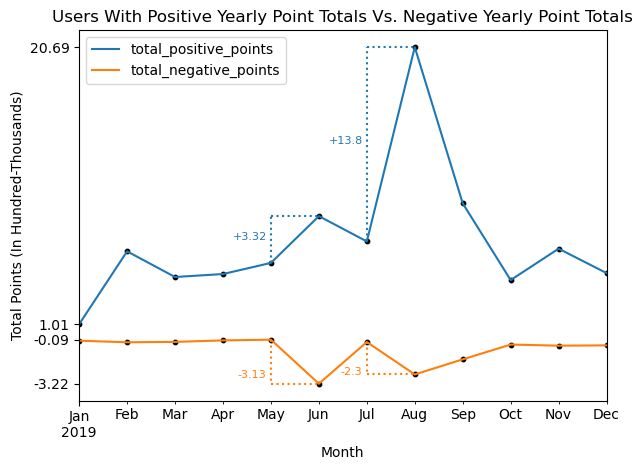

In [16]:
fig, ax = plt.subplots(1,1)

users_total_positive_points_per_month.plot(kind='line', legend=True, ax=ax)

ax.scatter(users_total_positive_points_per_month.index, 
           users_total_positive_points_per_month.values, 
           color='black', s=10)

ax.vlines('2019-05-01', ymin=may_positive_users_tot_pts, ymax=jun_positive_users_tot_pts, linestyle=':', color='tab:blue')
ax.hlines(jun_positive_users_tot_pts, xmin='2019-05-01', xmax='2019-06-01', linestyle=':', color='tab:blue')
ax.annotate(f'+{round((jun_positive_users_tot_pts-may_positive_users_tot_pts)/100_000,2)}',
               xy=('2019-05-01', may_positive_users_tot_pts+(jun_positive_users_tot_pts-may_positive_users_tot_pts)/2),
               textcoords='offset points',
               xytext=(-3,0), ha='right', color='tab:blue', fontsize=8)

ax.vlines('2019-07-01', ymin=jul_positive_users_tot_pts, ymax=aug_positive_users_tot_pts, linestyle=':', color='tab:blue')
ax.hlines(aug_positive_users_tot_pts, xmin='2019-07-01', xmax='2019-08-01', linestyle=':', color='tab:blue')
ax.annotate(f'+{round((aug_positive_users_tot_pts-jul_positive_users_tot_pts)/100_000,2)}',
               xy=('2019-07-01', jul_positive_users_tot_pts+(aug_positive_users_tot_pts-jul_positive_users_tot_pts)/2),
               textcoords='offset points',
               xytext=(-3,0), ha='right', color='tab:blue', fontsize=8)


users_total_negative_points_per_month.plot(kind='line', legend=True, ax=ax)

ax.scatter(users_total_negative_points_per_month.index, 
           users_total_negative_points_per_month.values, 
           color='black', s=10)

ax.vlines('2019-05-01', ymin=may_negative_users_tot_pts, ymax=jun_negative_users_tot_pts, linestyle=':', color='tab:orange')
ax.hlines(jun_negative_users_tot_pts, xmin='2019-05-01', xmax='2019-06-01', linestyle=':', color='tab:orange')
ax.annotate(f'{round((jun_negative_users_tot_pts-may_negative_users_tot_pts)/100_000,2)}',
               xy=('2019-05-01', may_negative_users_tot_pts+(jun_negative_users_tot_pts-may_negative_users_tot_pts)/2),
               textcoords='offset points',
               xytext=(-3,-12), ha='right', color='tab:orange', fontsize=8)

ax.vlines('2019-07-01', ymin=jul_negative_users_tot_pts, ymax=aug_negative_users_tot_pts, linestyle=':', color='tab:orange')
ax.hlines(aug_negative_users_tot_pts, xmin='2019-07-01', xmax='2019-08-01', linestyle=':', color='tab:orange')
ax.annotate(f'{round((aug_negative_users_tot_pts-jul_negative_users_tot_pts)/100_000,2)}',
               xy=('2019-07-01', jul_negative_users_tot_pts+(aug_negative_users_tot_pts-jul_negative_users_tot_pts)/2),
               textcoords='offset points',
               xytext=(-3,-12), ha='right', color='tab:orange', fontsize=8)


ax.set_title('Users With Positive Yearly Point Totals Vs. Negative Yearly Point Totals')

ax.set_xlabel('Month')
ax.set_yticks([negative_users_min_total, 
               negative_users_max_total, 
               positive_users_min_total, 
               positive_users_max_total])

ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(round(int(x)/100_000, 2), ',')))
ax.set_ylabel('Total Points (In Hundred-Thousands)')
plt.tight_layout();

The plot above was generated by segmenting users who have a positive total number of points earned over the course of the year from users who have a negative total number of points earned over the course of the year.  In the summary statistics part of this analysis, it was noted that 71% of users had positive yearly point totals, while 29% of users had negative yearly point totals.  

The blue line represents users with positive yearly point totals and closely mimics the previous graph, where the strongest performance tended to occur during the late spring and summer months; however, the orange line represents users with negative yearly point totals and tells a new part of the story.  

While June and August were the worst months for these users, these months are the exception to the rule.  In general, there is little variation in the number of points scored by these users in the remaining months, and their point scores stay fairly consistent.  This lends some evidence that these users consistently score poorly and are just not very good at the game.  They're going to be the ones on the very bottom of the leaderboards.

It's interesting to find that June and August had small spikes in point totals going in opposite directions for each kind of user.  For the users with a positive yearly point total, the graph spikes upward, indicating these people earned more points, while the graph moves down for the users with negative yearly point totals, showing they scored even worse than normal.  To summarize, in both of these months, the best users are scoring more AND the worst users are scoring less.   It might be something worth investigating what was going on during June and August.

## Total Points By Season and By Hour

In [17]:
sql_query = """
SELECT userid 
     , event_date
     , hour
     , points
     , CASE
            WHEN EXTRACT(MONTH FROM event_date) IN (3, 4, 5) THEN 'spring'
            WHEN EXTRACT(MONTH FROM event_date) IN (6, 7, 8) THEN 'summer'
            WHEN EXTRACT(MONTH FROM event_date) IN (9, 10, 11) THEN 'fall'
            ELSE 'winter'
        END AS season
  FROM event_performance;
"""

event_performance_with_seasons = sql_query_to_pandas_df(sql_query,
                                                        engine,
                                                        index_column='event_date',
                                                        dates_column='event_date')

In [18]:
event_performance_spring = event_performance_with_seasons[event_performance_with_seasons['season']=='spring']

event_performance_summer = event_performance_with_seasons[event_performance_with_seasons['season']=='summer']

event_performance_fall = event_performance_with_seasons[event_performance_with_seasons['season']=='fall']

event_performance_winter = event_performance_with_seasons[event_performance_with_seasons['season']=='winter']

hourly_point_totals_spring = event_performance_spring.groupby('hour').agg(sum)[['points']]

hourly_point_totals_summer = event_performance_summer.groupby('hour').agg(sum)[['points']]

hourly_point_totals_fall = event_performance_fall.groupby('hour').agg(sum)[['points']]

hourly_point_totals_winter = event_performance_winter.groupby('hour').agg(sum)[['points']]

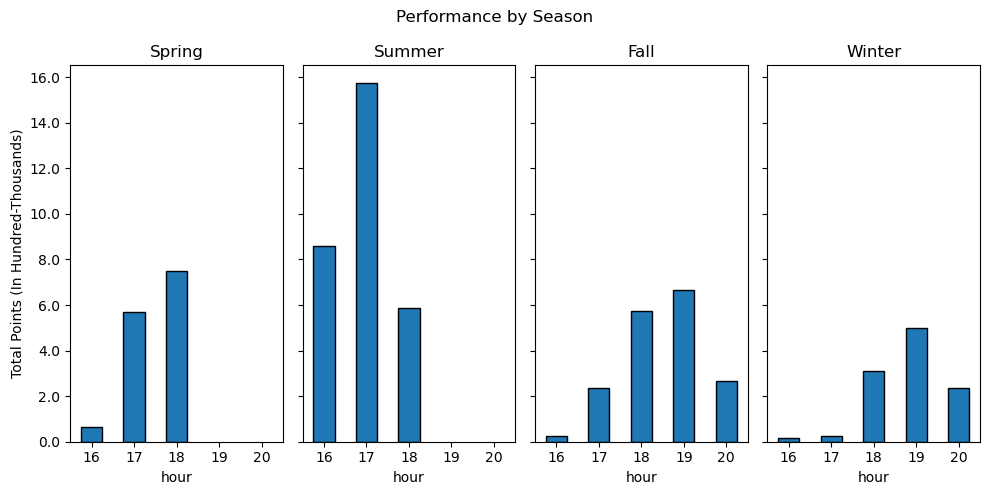

In [19]:
fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(10,5))

fig.suptitle('Performance by Season')

hourly_point_totals_spring.plot(kind='bar', legend=False, ax=ax[0], edgecolor='black', rot=0)
ax[0].set_title('Spring')
ax[0].set_ylabel('Total Points (In Hundred-Thousands)')
ax[0].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(round(int(x)/100_000, 2), ',')))

hourly_point_totals_summer.plot(kind='bar', legend=False, ax=ax[1], edgecolor='black', rot=0)
ax[1].set_title('Summer')

hourly_point_totals_fall.plot(kind='bar', legend=False, ax=ax[2], edgecolor='black', rot=0)
ax[2].set_title('Fall')

hourly_point_totals_winter.plot(kind='bar', legend=False, ax=ax[3], edgecolor='black', rot=0)
ax[3].set_title('Winter')

plt.tight_layout();

Because it was noticed earlier that total points earned per month showed some seasonality, it's worth looking at performance for each season, spring, summer, fall, and winter.

The graph above shows hourly totals of points earned for each season and reveals a few interesting things.  To begin, gaming events only occur in the evening hours, starting as early as hour 16 and going as late as hour 20.  In spring and summer, the general trend is that more points are earned in earlier hours, while in fall and winter, more points are earned in later hours.  Furthermore, spring and summer have no points earned during hours 19 and 20, yet in fall and winter, most points are earned in hour 19. Regardless of the season, the trend is that more points are earned hour by hour until reaching a peak, and then points earned steadily decline afterwards.

**This is important to know because this information can be used to target gaming events during times of the day that will see more user engagement and more points earned based on the season.  In spring and summer, earlier hours should be preferred, whereas in fall and winter, later hours should be preferred.**

## Total Points Per Gaming Event

In [20]:
sql_query = """
  SELECT DATE_TRUNC('day', event_date)::date AS day
       , SUM(points) AS total_points
    FROM event_performance
GROUP BY DATE_TRUNC('day', event_date)::date
ORDER BY 1;
"""

total_points_per_day = sql_query_to_pandas_df(sql_query,
                                              engine,
                                              index_column='day',
                                              dates_column='day')

In [21]:
sql_query = """
WITH total_points_per_day AS (
  SELECT DATE_TRUNC('day', event_date)::date AS day
       , SUM(points) AS total_points
    FROM event_performance
GROUP BY DATE_TRUNC('day', event_date)::date
)

  SELECT day
       , total_points
    FROM total_points_per_day
   WHERE total_points = (SELECT MIN(total_points) FROM total_points_per_day)
      OR total_points = (SELECT MAX(total_points) FROM total_points_per_day);
"""

extreme_points_days = sql_query_to_pandas_df(sql_query,
                                             engine,
                                             index_column='day',
                                             dates_column='day')

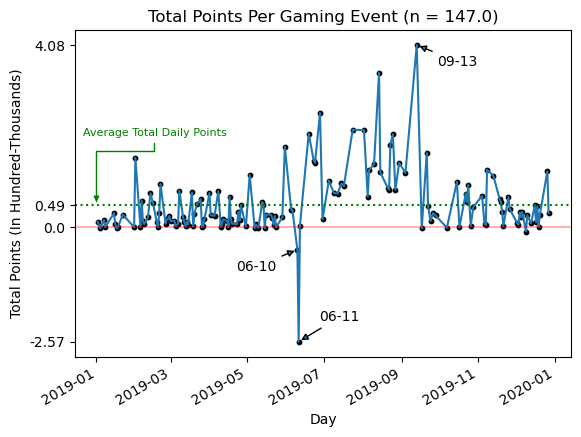

In [22]:
num_gaming_events = quantitative_summary_stats.loc['num_gaming_events'][0]

min_day = extreme_points_days.index.strftime('%m-%d').values[0]
max_day = extreme_points_days.index.strftime('%m-%d').values[1]

min_total_pts_per_day = extreme_points_days['total_points'][0]
max_total_pts_per_day = extreme_points_days['total_points'][1]

avg_tot_pts_per_day = total_points_per_day.mean().values[0]

fig, ax = plt.subplots(1,1)

total_points_per_day.plot(kind='line', legend=False, ax=ax)
ax.scatter(total_points_per_day.index, total_points_per_day.values, color='black', s=10)

ax.set_title(f'Total Points Per Gaming Event (n = {num_gaming_events})')
ax.set_xlabel('Day')
ax.set_yticks([min_total_pts_per_day, 0, avg_tot_pts_per_day, max_total_pts_per_day])
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(round(int(x)/100_000, 2), ',')))
ax.set_ylabel('Total Points (In Hundred-Thousands)')

ax.axhline(avg_tot_pts_per_day, linestyle=':', color='green')
ax.axhline(0, color='red', alpha=0.3)

ax.annotate("Average Total Daily Points", 
            xy=('2019-01-01', avg_tot_pts_per_day), 
            xytext=(-10,50), 
            textcoords="offset points", 
            c='green', 
            fontsize=8, 
            ha='left', 
            arrowprops=dict(arrowstyle='-|>', 
                            color='green', 
                            connectionstyle="bar,angle=180, fraction=-0.2"))

ax.annotate(f'{min_day}', 
            xy=(extreme_points_days.index[0], 
                extreme_points_days.values[0]), 
            xytext=(15, 15), 
            textcoords='offset points', 
            arrowprops=dict(arrowstyle='-|>'))
ax.annotate(f'06-10', 
            xy=('2019-06-10', -51051), 
            xytext=(-15, -15), 
            textcoords='offset points',
            ha='right', 
            arrowprops=dict(arrowstyle='-|>'))
ax.annotate(f'{max_day}', 
            xy=(extreme_points_days.index[1], 
                extreme_points_days.values[1]), 
            xytext=(15, -15), 
            textcoords='offset points', 
            arrowprops=dict(arrowstyle='-|>'));

The graph above shows the total points earned for each of the 147 gaming events present in the dataset.  The vast majority of points lie above 0, further confirming what was seen earlier, most gaming events end with the users having a positive point total and winning.  However, many of these point total are below average despite users winning, they don't win by a large margin and earn minimal prizes.

On the other hand, virtually all gaming events found during the months of June through September have above average performance, with the most successful day of the year happening on September 13th.  This isn't too surprising, as it was found earlier in the analysis that the late spring and summer months had the best performance throughout the year.  

In the summary statistics from earlier, it was noted that one day had the worst performance with -257,483 points earned, which appears to correspond to July 11th.  Furthermore, the second worst performing day of the year occurs on July 10th.  It would be worth spending time to understand what happened on those days and why user performance was so poor.

**These observations are important for two reasons:**
1. **They further reinforce the idea that increasing user participation and user performance outside of late spring and summer is important to foster growth and generate revenue.**
2. **While late spring and summer months consistently perform well, these months also had the two days that performed worst by a large margin.  Understanding why there are such large extremes during these seasons could be helpful.**

# Top two performers by month.

In [23]:
sql_query = """
WITH points_rankings AS (
	  SELECT userid
	       , EXTRACT(MONTH FROM event_date) AS month
	       , SUM(points) AS points_earned
	       , DENSE_RANK() OVER (PARTITION BY EXTRACT(MONTH FROM event_date) 
	     					  ORDER BY SUM(points) DESC
	     					  ) AS ranking
	    FROM event_performance
	GROUP BY userid, EXTRACT(MONTH FROM event_date)
	)

      SELECT userid
           , month
           , points_earned
           , ranking
        FROM points_rankings
       WHERE ranking <= 2
    ORDER BY month, ranking;
"""

top_2_performers_per_month = sql_query_to_pandas_df(sql_query,
                                                    engine)

top_2_performers_per_month

,userid,month,points_earned,ranking
0,2d172cc1-15b2-4442-9fa6-82b30d77683d,1.0,4505,1
1,c146f69c-bffb-44dc-84bd-faf9360144cd,1.0,3403,2
2,424fc967-5e61-4e77-afd8-619b03cec9e4,2.0,15006,1
3,2f88e915-6a2a-4023-ab33-3c5923f54125,2.0,13747,2
4,dd77d0a4-c35c-4e36-867f-339d4f114c2e,3.0,9608,1
5,8009bd3a-2c2c-465e-b7cb-7e051d399572,3.0,9042,2
6,87898b2b-bd3a-4702-ad6e-f259b39796f5,4.0,11899,1
7,dd77d0a4-c35c-4e36-867f-339d4f114c2e,4.0,11095,2
8,dd77d0a4-c35c-4e36-867f-339d4f114c2e,5.0,18418,1
9,2d172cc1-15b2-4442-9fa6-82b30d77683d,5.0,11017,2


Here can be seen the top 2 best performing userids for all 12 months during the year.  There are several users who come up multiple times in the list and have extremely large point totals for just a single month.  

Circling back to the summary statistics from earlier it was noted that there were different distributions of users based on two variables, subscriber and category.  Could there be some correlation between high point scores and these user attributes?

# Correlation
The goal here is to answer the following questions:
1.  Is there any correlation between user attributes and points earned?  
2.  If so, can the correlation be quantified in some way?

## Assumptions

1. The correlation we're interested in is between user attributes and yearly points earned.
2. If a userid is found in the users table but not in the event performance table, that's because that userid never participated in a gaming event and thus has scored 0 points for the year.
3. subscriber is binary variable, taking on only values of 0 or 1.
4. category is a nominal categorical variable with only three levels: A, B, or C.  Because category is nominal, there is no ordering to the levels.

## Joining Tables

In [24]:
sql_query = """
WITH total_points_per_user AS (
   SELECT userid
        , SUM(points) AS total_points
     FROM event_performance
 GROUP BY userid
  )

   SELECT u.userid
        , u.subscriber
        , u.category
        , COALESCE(tp.total_points, 0) AS total_points
     FROM users AS u
LEFT JOIN total_points_per_user AS tp
       ON u.userid = tp.userid;
"""

users_attributes_and_tot_points = sql_query_to_pandas_df(sql_query,
                                                         engine)

## Checking Correlation

### Visualizing Correlation

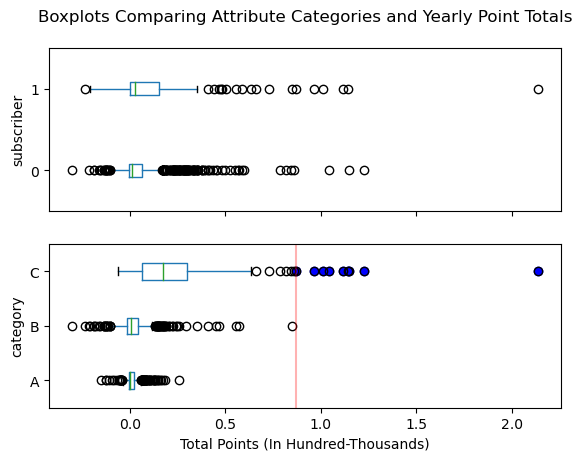

In [25]:
fig, ax = plt.subplots(2, 1, sharex=True)

boxplot1 = users_attributes_and_tot_points.boxplot('total_points', by='subscriber', ax=ax[0], vert=False, return_type='both')
ax[0].set_title(None)
ax[0].grid(None)
ax[0].get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(round(int(x)/100_000, 2), ',')))

boxplot2 = users_attributes_and_tot_points.boxplot('total_points', by='category', ax=ax[1], vert=False, return_type='both')
ax[1].set_title(None)
ax[1].grid(None)
ax[1].set_xlabel('Total Points (In Hundred-Thousands)')



fig.suptitle('Boxplots Comparing Attribute Categories and Yearly Point Totals')

x = boxplot2[0][-1]['fliers'][2].get_xdata()
y = boxplot2[0][-1]['fliers'][2].get_ydata()
x.sort()
y.sort()
x = x[6:]
y = y[6:]

ax[1].scatter(x, y, color='blue')

ax[1].axvline(x.min(), color='red', linestyle='solid', alpha=0.3);

The first boxplot shows roughly the same spread of point totals regardless of whether a user is a subscriber or not. The medians are close, and the overall distribution of point totals is pretty similar. My initial impression is that there's either no correlation or a weak correlation between whether a user is a subscriber and their yearly point totals.

On the other hand, the second boxplot shows more noticeable differences between the three categories: A, B, and C. Category A and B have fairly similar performance, although category A has a little less variability than category B. However, category C is quite different and is the most interesting.

The plot reveals point totals for category C are skewed right and look to be the strongest performing group.  Very few users in this category have yearly point totals that are negative, and therefore these users must be consistently contributing to the human team's bottom line.

Additionally, category C contains the users with the 9 highest point totals of the year, and it seems unlikely for that to be a coincidence.  This can be seen in the graph, where the red line represents the 9th highest point total of the year.  The nine players who scored at least that many points are represented by the colored circles to the right.

### Subscriber

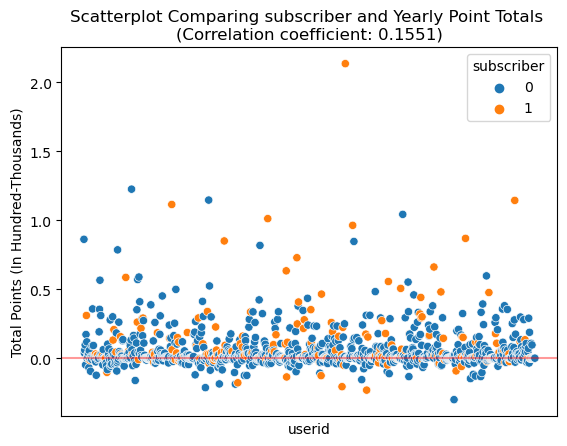

In [26]:
corr=users_attributes_and_tot_points['total_points'].corr(users_attributes_and_tot_points['subscriber'])

ax = sns.scatterplot(x=users_attributes_and_tot_points.index,
                     y='total_points',
                     data=users_attributes_and_tot_points,
                     hue='subscriber')
ax.axhline(y=0, linestyle='solid', color='red', alpha=0.4)
ax.set_xticks([])
ax.set_xlabel('userid')
ax.set_ylabel('Total Points (In Hundred-Thousands)')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(round(int(x)/100_000, 2), ',')))

ax.set_title(f'Scatterplot Comparing subscriber and Yearly Point Totals \n(Correlation coefficient: {corr:.4f})');

Each dot in the scatterplot above represents a unique userid and their yearly point total.  Most dots are clustered together above or below 0, and there doesn't appear to be any noticeable pattern.  Because 81% of users are not subscribers, most of the dots are blue, but there are good amounts of both orange and blue points in the higher point totals, as well as the lower point totals, and there isn't much evidence that one type of user will score much differently from the other.  Everything here confirms what was seen in the box plot earlier: there doesn't seem to be much correlation between whether a user is a subscriber and points earned.  

Since both subscriber and total points are quantitative, Pearson's correlation coefficient can be calculated. The correlation coefficient is 0.1551, indicating a weak correlation; however, this could be true of our sample data and not necessarily true in the greater population.  To check, a t-test must be performed.

In [27]:
X = users_attributes_and_tot_points.loc[:, ['subscriber']]
X = sm.add_constant(X)
y = users_attributes_and_tot_points.loc[:, ['total_points']]

linear_model_subscriber = sm.OLS(y, X).fit()

In [28]:
subscriber_summary_results = linear_model_subscriber.conf_int()

subscriber_summary_results.rename(mapper={0:'95%_conf_int_lower', 
                                          1:'95%_conf_int_upper'}, 
                                  axis=1, inplace=True)

subscriber_summary_results['pvalues'] = linear_model_subscriber.pvalues
subscriber_summary_results['coefficients'] = linear_model_subscriber.params

subscriber_summary_results = subscriber_summary_results[['coefficients', 
                                                         'pvalues', 
                                                         '95%_conf_int_lower', 
                                                         '95%_conf_int_upper']]

round(subscriber_summary_results.loc[['subscriber']], 4)

,coefficients,pvalues,95%_conf_int_lower,95%_conf_int_upper
subscriber,"6,684.8246",0.0,"4,163.9272","9,205.7219"


#### Peforming a t-test

$H_0:$ There is no significant correlation between subscriber and total_points

$H_a:$ There is a significant correlation between subscriber and total_points

At the $\alpha=0.05$ level of significance, the P-value is ~0 and the null hypothesis should be rejected.  This indicates there is sufficient evidence to conclude that subscriber is statistically significant when predicting total points.  

The summary output from above shows that the coefficient for subscriber is 6,684.8246, meaning that on average, someone who has subscriber = 1 will earn 6,684.8246 points more than someone with subscriber = 0.  We are 95% confident that the true increase in points earned for those with subscriber = 1 is between 4,163.9272 and 9,205.7219 points. 

#### Checking Assumptions of Linear Regression to Determine Validity of the Results

In order for the results from linear regression to be valid, four main conditions must be met:
    
1. Linearity: The relationship between X and Y must be linear.
2. Independence of Errors: There is no relationship between the residuals and the fitted (predicted) Y variable.
3. Normality of Errors: The residuals must be approximately normally distributed.
4. Equal Variances: The variance of the residuals is the same across all values of X.

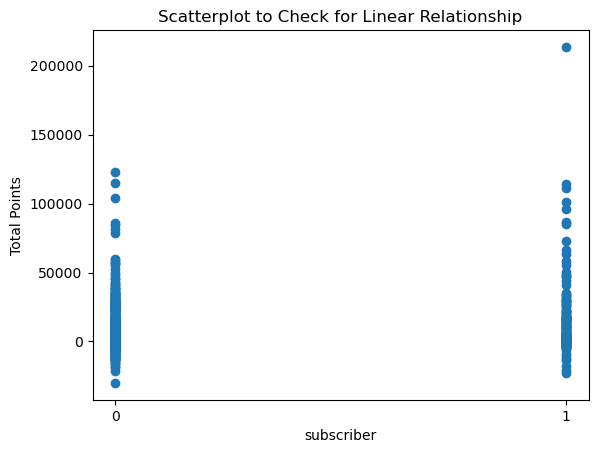

In [29]:
fig, ax = plt.subplots(1,1)

ax.scatter(users_attributes_and_tot_points['subscriber'], 
           users_attributes_and_tot_points['total_points'])

ax.set_title('Scatterplot to Check for Linear Relationship')
ax.set_xlabel('subscriber')
ax.set_xticks([0,1])
ax.set_ylabel('Total Points');

The scatter plot doesn't show any indication that the first assumption is violated.  A linear model could be reasonable for this relationship.

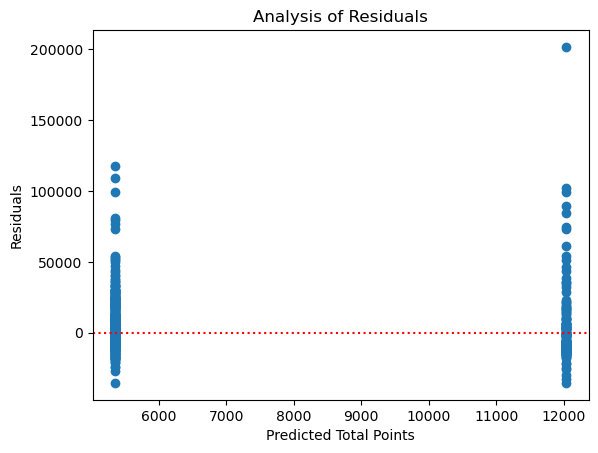

In [30]:
preds = linear_model_subscriber.predict(X)
residuals = users_attributes_and_tot_points['total_points'] - preds

fig, ax = plt.subplots(1,1)

ax.scatter(preds, residuals)
ax.axhline(0, color='red', linestyle=':')
ax.set_xlabel('Predicted Total Points')
ax.set_ylabel('Residuals')
ax.set_title('Analysis of Residuals');

The residual plot doesn't show any indication that the second or fourth assumption is violated.  Because all points are scattered above and below 0, there's no systematic pattern in the residuals and the plot doesn't show any relationship between residuals and total points (second assumption).  Furthermore, the spread across all residuals is roughly the same and therefore the variance of the residuals is roughly the same (fourth assumption).

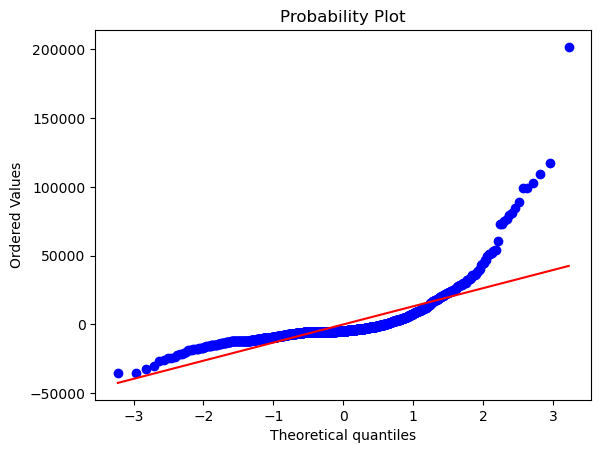

In [31]:
stats.probplot(residuals, plot=plt);

Most of the data points lie close to the straight line; however, there is slight curving, most noticeably on the right side.  This indicates that the residuals may not be normally distributed, which violates the third assumption.

All of the assumptions except for the assumption of normal residuals seem valid, and therefore the conclusion that a correlation exists between subscriber and total points earned is still reasonable, although it should be taken with a grain of salt.

### Category

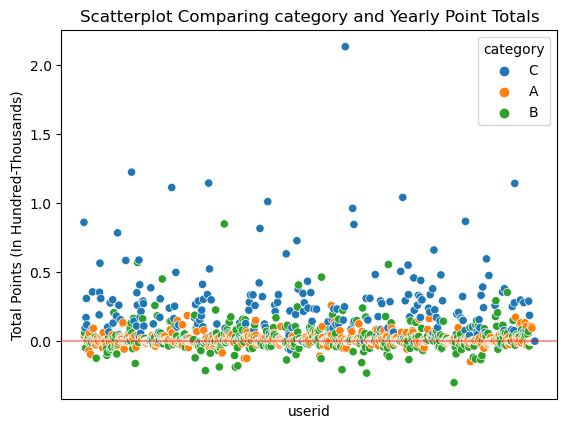

In [32]:
ax = sns.scatterplot(x=users_attributes_and_tot_points.index,
                     y='total_points',
                     data=users_attributes_and_tot_points,
                     hue='category')
ax.axhline(y=0, linestyle='solid', color='red', alpha=0.4)
ax.set_title('Scatterplot Comparing category and Yearly Point Totals')
ax.set_xticks([])
ax.set_xlabel('userid')
ax.set_ylabel('Total Points (In Hundred-Thousands)')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(round(int(x)/100_000, 2), ',')));

Each dot in the scatterplot above represents a unique userid and their yearly point total, which further sheds light on the patterns identified in the box plots from earlier.

Firstly, nearly all users with category = C have positive yearly totals, and these users tend to have the best performance as they're the most common color found in the higher point totals.  Users with category = A are clustered close to 0 and have a tendency to have either slightly above or below 0 total points.  In comparison, most users with category = B are also clustered close to 0, but are a little more spread out and show more variation in point totals.  

Since category is categorical, Pearson's correlation coefficient can't be computed at the moment; however, a One Way ANOVA test can be performed to determine if a correlation exists.

#### Performing a One Way ANOVA test

In [33]:
category_lists = users_attributes_and_tot_points.groupby('category')['total_points'].apply(list)

anova_results = stats.f_oneway(*category_lists)

print(f'P-Value: {anova_results.pvalue:.4f}')

P-Value: 0.0000


$H_0$: category and total yearly points are not correlated

$H_a$: category and total yearly points are correlated

At the $\alpha=0.05$ level of significance, the P-value is ~0 and the null hypothesis should be rejected.  This indicates there is sufficient evidence to conclude that category is correlated with yearly point totals.

One downside to this test is that it doesn't indicate which level(s) of category are most correlated with total points earned; however, we can encode category using dummy variables and check the strength of the correlation that way. 

#### Dummy variables and quantifying correlation

In [34]:
dummy_df = pd.get_dummies(users_attributes_and_tot_points, columns=['category'], dtype=float)

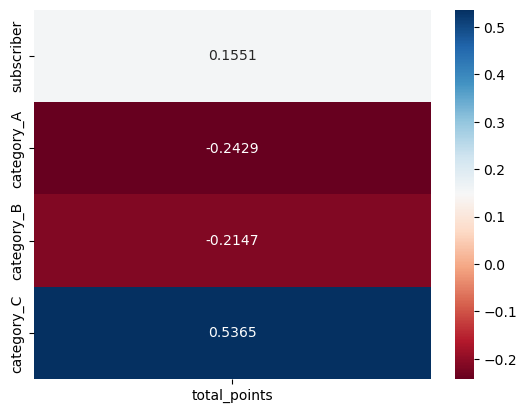

In [35]:
correlations = dummy_df[['subscriber', 'category_A', 'category_B', 'category_C', 'total_points']].corr()

x=correlations[['total_points']][0:4]


sns.heatmap(x, annot=True, cmap='RdBu', fmt='.4g');

A simple heatmap shows that both category A and B have weak/moderate negative correlations with total points earned, -0.24 and -0.21, respectively, although category A is slightly more negatively correlated.  On the other hand, category C has a moderately positive correlation with total points earned of 0.54.

#### Building a Multiple Linear Regression

In [36]:
X = dummy_df.loc[:, ['subscriber', 'category_B', 'category_C']]
X = sm.add_constant(X)
y = dummy_df.loc[:, ['total_points']]

linear_model_all = sm.OLS(y, X).fit()

In [37]:
tbl = linear_model_all.summary2().tables[1]
round(tbl, 4)

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,114.4202,703.8912,0.1626,0.8709,"-1,266.7066","1,495.5469"
subscriber,"7,258.8017","1,077.4173",6.7372,0.0,"5,144.768","9,372.8354"
category_B,617.8321,944.3979,0.6542,0.5131,"-1,235.2002","2,470.8643"
category_C,"22,002.3214","1,114.5508",19.741,0.0,"19,815.4269","24,189.2158"


In order to avoid the dummy variable trap, regression has to be performed using all but one level of the dummy variable, which acts as the baseline level for comparison.  In this model, category A represents the baseline level for the dummy variable, and any coefficients of the model must be interpreted relative to that category.

The model will have the following form: $\hat{y} = \beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_3$, where $x_1$, $x_2$, and $x_3$ correspond to the coding scheme:

<ul>
											<li>
												$x_1 = \left\{\begin{aligned} 
													1 &\text{ if userid is a paid subscriber} \\
													0 &\text{ if userid is not a paid subscriber}
												\end{aligned} \right.$
											</li><br>
											<li>
												$x_2 = \left\{\begin{aligned} 
													1 &\text{ if userid is in category B} \\
													0 &\text{ if userid is not in category B}
												\end{aligned} \right.$
											</li><br>
											<li>
												$x_3 = \left\{\begin{aligned} 
													1 &\text{ if userid is in category C} \\
													0 &\text{ if userid is not in category C}
												\end{aligned} \right.$
											</li><br>
										</ul>
                                        
After plugging in the coefficients generated by the summary output, the model looks like this: $\hat{y}=114.4202+7258.8017x_1+617.8321x_2+22002.3214x_3$.

Understanding how to interpret the model will help understand the relationship between user attributes and user performance.  When $x_1, x_2$, and $x_3$ are all set to 0, you have your baseline user, a non-subscriber, who is neither in category B nor in category C; therefore, they must be in category A.  For this kind of user, the model's predicted yearly point total would simply be the constant 114.4202.  

If $x_2$ is set to 1 and all other variables remain 0, then this would represent a non-subscriber in category B.  For this kind of user, the predicted yearly point total would increase by the coefficient of 617.8321 points.  This indicates that, on average, non-subscribers in category B earn 617.8321 points more than non-subscribers in category A.  This echoes what was seen earlier regarding there not being much difference in point scores between users in these categories.

When $x_3$ is set to 1 and all other variables remain 0, the user is a non-subscriber in category C.  For this kind of user, the model would predict a yearly point total of 22,002.314 points higher than the baseline user.  This is the largest coefficient of the model and emphasizes just how strong the performance of users in category C really is.

When $x_1 = 1$, this indicates the user is a subscriber.  Users of any category can be subscribers; therefore, regardless of the values of $x_2$ or $x_3$, $x_1$ could be set to one and "turned on".  Turning on $x_1$ would increase the model's prediction of yearly point totals by its coefficient of 7258.8017, meaning that a subscribing user is predicted to earn that many points more than a non-subscribing user from the same category.  Despite earlier identifying subscriber as having a weak correlation, it produces the second largest effect on predicted yearly point totals in this model and looks to be more important than was initially thought.

## Conclusions

In summary, it seems as though the question of whether there's any correlation between user attributes and user performance has been answered.  Both subscriber and category are statistically significant predictors of a user's performance as measured through their yearly point totals.  The single best predictor is which category a user falls into, with category C being the most important; however, knowing whether a user is a subscriber or not is pretty important too.

# The End